In [1]:
using BSON
using BSON: @save, @load
using Statistics
using DelimitedFiles
using Printf
using MDToolbox
using StatsBase 
using LinearAlgebra
using Random
using Plots

include("../src/afm.jl")

baumwelch (generic function with 1 method)

In [2]:
nq = 576
probe_radius = 25
pred_radii = [15, 18, 20, 25, 30, 32, 35]
#pred_radii_str = ["1.8", "2.0", "2.5", "3.0", "3.2"]
sigma_noise = 3
sharpness = 10
nframe = 100
resolution = 6.25 * 0.1
nmodel = 50

50

In [3]:
@load "../data/t1r/t1r.bson" T pi_i centroid p_all
#r = BSON.load("../data/t1r/t1r.bson"
true_T = deepcopy(T)
true_pi_i = deepcopy(pi_i);

In [4]:
p = msmplot(true_T, pi_i=true_pi_i, x=centroid[:, 1], y=centroid[:, 2], 
            nodesize=1.2, edgewidth_scale=8.0, arrow_scale=0.001, 
            dpi=300)

In [5]:
savefig(p, "fig06_ground_truth.png")

"/data/yasu/seica/01_psudo_test/fig06_ground_truth.png"

In [6]:
learned_Ts = []
learned_pis = []
ids_list = []
for r in pred_radii
    @load "data/viterbi/test_radius_$(probe_radius)_sigma_6/pred_radius_$(r)/sharpness_$(sharpness)/q_$(nq)/T_baumwelch.bson" T learned_T learned_pi_i obs_list log_emission ids nid
    push!(learned_Ts, learned_T)
    push!(learned_pis, learned_pi_i)
    push!(ids_list, ids)
end

In [7]:
function make_merged_T(ids, T, p, nmodel)
    ret_T = zeros(nmodel, nmodel)
    ret_p = zeros(nmodel)
    for i in 1:length(ids)
        i_state = ids[i][1]
        for j in 1:length(ids)
            j_state = ids[j][1]
            ret_T[i_state, j_state] += T[i, j]
        end

        ret_p[i_state] += p[i]
    end

    for i in 1:nmodel
        if sum(ret_T[i, :]) <= 1e-100
            continue 
        end
        ret_T[i, :] ./= sum(ret_T[i, :])
    end

    return ret_T, ret_p
end

make_merged_T (generic function with 1 method)

In [8]:
learned_Ts2 = []
learned_pis2 = []
for i = 1:length(pred_radii)
    t, p = make_merged_T(ids_list[i], learned_Ts[i], learned_pis[i], nmodel)
    #t, p = msmtransitionmatrix(t)
    push!(learned_Ts2, t)
    push!(learned_pis2, p)
end

In [9]:
i = 7
pp = msmplot(learned_Ts2[i], pi_i=learned_pis2[i], x=centroid[:, 1], y=centroid[:, 2], 
            nodesize=1.2, edgewidth_scale=8.0, arrow_scale=0.001, 
            dpi=300)

In [10]:
savefig(pp, "fig06_35A_sigma6.png")

"/data/yasu/seica/01_psudo_test/fig06_35A_sigma6.png"

In [11]:
function compute_relative_entropy(p_ref, T_ref, T)
    T_ref2 = deepcopy(T_ref)
    T2 = deepcopy(T)
    T_ref2 .+= 10^(-8)
    T2 .+= 10^(-8)
    T_ref2 .= T_ref2 ./ sum(T_ref2, dims=2)
    T2 .= T2 ./ sum(T2, dims=2)

    nmodel = size(T_ref, 1)
    d = 0.0
    for i = 1:nmodel
        for j = 1:nmodel
            d += p_ref[i] * T_ref2[i, j] * log( T_ref2[i,j] / T2[i,j] )
        end
    end
    
    return d
end

compute_relative_entropy (generic function with 1 method)

In [12]:
compute_relative_entropy(true_pi_i, true_T, learned_Ts2[3])

0.5444623526314861

In [13]:
d_list = []
for i = 1:length(pred_radii)
    d = compute_relative_entropy(true_pi_i, true_T, learned_Ts2[i])
    push!(d_list, d)
end

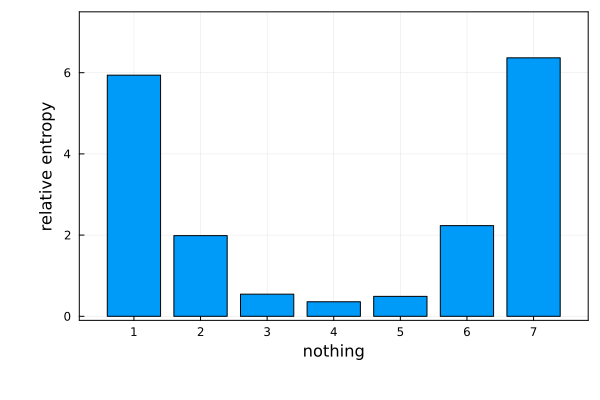

In [14]:
p = bar(d_list, 
        label=nothing, framestyle=:box,
        xlabel=nothing, ylabel="relative entropy",
        size=(600, 400), dpi=300, ylim=(-0.1, 7.5), 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [15]:
savefig(p, "fig06_relative_entropy_sigma6.png")

"/data/yasu/seica/01_psudo_test/fig06_relative_entropy_sigma6.png"